# Model Application

In [1]:
# load packages
import mlflow
import yaml
import numpy as np
import pandas as pd
import pickle
# import pickle 5 as pickle in case model cannot be loaded (was exported under Python 3.8)
#import pickle5 as pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [19]:
# read in (yaml) configs'
with open('../conf/predict_config.yaml', 'r') as conf:
    model_config = yaml.safe_load(conf)

# import data
dataset = model_config['model']['loc'] + model_config['model']['file']
dataset = pd.read_csv(dataset)

#define predictors and target variable
predictor = model_config['features']['predictors']
target = model_config['features']['target']

In [20]:
# prepare data
X = dataset[predictor]
y = dataset[target]
print('X Shape:', X.shape)
print('y Shape:', y.shape)

X Shape: (11732, 12)
y Shape: (11732, 1)


In [21]:
# load the model from model folder
filename = model_config['model']['model_loc'] + model_config['model']['champion'] 
model = pickle.load(open(filename, 'rb'))

# apply model on dataset and add predictions as column
# import pickle 5 as pickle in case model cannot be loaded 
# (was exported under Python 3.8) - see first cell
y_pred = model.predict(X)
dataset["y_pred"] = y_pred

## Setup dataset 

In [22]:
#remove initial pixel population data
dataset = dataset.drop(columns = "population")

#load and merge population data, with information on absolute school area population 
popread = open(model_config['model']['loc'] + model_config['model']['population']+ str(model_config["country_3digit"]) + ".csv")
popdata = pd.read_csv(popread)

dataset = dataset.merge(popdata, how ='inner')

In [23]:
#load and merge school data, with additional information about schools (name, internet & computer availability)
schoolread = open(model_config['model']['loc'] + model_config['model']['school'])
schooldata = pd.read_csv(schoolread)
schooldata = schooldata[["source_school_id", "school_name", "internet_availability", "computer_availability"]]
dataset = dataset.merge(schooldata, how = "inner")

Please adjust the file name above to the respective file that contains schools geolocation and further information. The same holds true for the additional school data variable names. They can be excluded or altered, depending on the dataset at hand. If schools are pulled from OSM, this entire chunk should be neglected.

In [24]:
#adjust predictions that exceed [0;1]
dataset.y_pred = [1 if x>1 else x for x in dataset.y_pred]
dataset.y_pred = [0 if x<0 else x for x in dataset.y_pred]

dataset.y_pred.describe()

count    11732.000000
mean         0.726126
std          0.190057
min          0.000000
25%          0.622446
50%          0.747617
75%          0.861043
max          1.000000
Name: y_pred, dtype: float64

In [25]:
#create lists of total online population according to predction and GT
dataset["target"]=dataset[target]
onlinepop_pred = (dataset.population * dataset.y_pred)
onlinepop_gt = (dataset.population * dataset.target)

#create variables for relative and absolute offline population
dataset["offline_p"]= 1- dataset.y_pred
dataset["offline_g"]= 1- dataset[target]
dataset["offlinepop_pred"] = dataset.population * dataset.offline_p
dataset["offlinepop_gt"] = dataset.population * dataset.offline_g
onlinepop_gt.head()

0    21621.277
1    25260.330
2    32302.738
3    25429.062
4    33929.700
dtype: float64

## Priorization

In [26]:
#subset relevant variables for priorization list export
prio = dataset[["source_school_id","school_name", "offlinepop_pred", "offline_p", "offline_g","internet_availability","computer_availability"]]
#If schools are pulled from OSM, the line below should be used for export. These variables are the minimum information
#that can always be exported. This also holds true for the other exports below 
#prio = dataset[["source_school_id", "offlinepop_pred", "offline_p", "offline_g"]]

prio.head()

,source_school_id,school_name,offlinepop_pred,offline_p,offline_g,internet_availability,computer_availability
0,11000023,EEEE ABNAEL MACHADO DE LIMA - CENE,0.000000,0.000000,0.0,Yes,Yes
1,11001364,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,0.000000,0.000000,0.0,Yes,Yes
2,11003138,I M E ENG,0.000000,0.000000,0.0,Yes,Yes
3,11003200,EEEF NOSSA SENHORA DO AMPARO,1307.334337,0.051411,0.0,Yes,Yes
4,11045175,EMEF JOAO RIBEIRO SOARES,0.000000,0.000000,0.0,Yes,No


In [30]:
#sort descendingly according to absolute offline population 
prio = prio.sort_values("offlinepop_pred", ascending = False)
print(prio.head())
#export priorization list
prio.to_excel(model_config['model']['loc'] + "predictions/Total_Priorization_List.xlsx", index = False)

      source_school_id                                       school_name  \
8924          33068372  0209021 ESCOLA MUNICIPAL PRESIDENTE JOAO GOULART   
8911          33068216          0209019 ESCOLA MUNICIPAL AFRANIO PEIXOTO   
4316          33067783                               CE FRANCISCO CAMPOS   
217           13026720                   EM PROF RICARDO PEREIRA PARENTE   
4317          33068275         0209025 ESCOLA MUNICIPAL FRANCISCO CAMPOS   

      offlinepop_pred  offline_p  offline_g internet_availability  \
8924    101306.713968   0.998751        1.0                   Yes   
8911     90077.484000   1.000000        1.0                   Yes   
4316     86641.545636   0.999616        1.0                   Yes   
217      83041.914000   1.000000        1.0                   Yes   
4317     80645.323116   0.930435        1.0                   Yes   

     computer_availability  
8924                   Yes  
8911                    No  
4316                   Yes  
217         

In [27]:
#Creating a geodataframe
from shapely import wkt
#Changing dataframe into a geodataframe focused on the school geometry column
dataset['School'] = gpd.GeoSeries.from_wkt(dataset['School'])
gdf = gpd.GeoDataFrame(dataset, geometry='School')
#gdf.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,School,source_school_id,geometry,index_right,...,y_pred,population,school_name,internet_availability,computer_availability,target,offline_p,offline_g,offlinepop_pred,offlinepop_gt
0,0,0,0,0,0,0,POINT (-63.85400 -8.75850),11000023,"POLYGON ((-63.844 -8.7585, -63.84404815273328 ...",5,...,0.947278,21621.277,EEEE ABNAEL MACHADO DE LIMA - CENE,Yes,Yes,1.0,0.052722,0.0,1139.917762,0.0
1,1,1,1,1,1,57,POINT (-63.86420 -8.76270),11001364,"POLYGON ((-63.8542 -8.762700000000001, -63.854...",5,...,0.993212,25260.330,EEEFM JUSCELINO KUBITSCHEK DE OLIVEIRA,Yes,Yes,1.0,0.006788,0.0,171.456969,0.0
2,2,2,2,2,2,117,POINT (-63.85540 -8.75790),11003138,POLYGON ((-63.84540000000001 -8.75789999999999...,5,...,0.960947,32302.738,I M E ENG,Yes,Yes,1.0,0.039053,0.0,1261.508013,0.0
3,3,3,3,3,3,121,POINT (-63.86460 -8.75730),11003200,"POLYGON ((-63.8546 -8.757300000000001, -63.854...",5,...,0.954114,25429.062,EEEF NOSSA SENHORA DO AMPARO,Yes,Yes,1.0,0.045886,0.0,1166.834402,0.0
4,4,4,4,4,4,862,POINT (-63.85540 -8.74680),11045175,"POLYGON ((-63.84540000000001 -8.7468, -63.8454...",5,...,0.937994,33929.700,EMEF JOAO RIBEIRO SOARES,Yes,No,1.0,0.062006,0.0,2103.854978,0.0


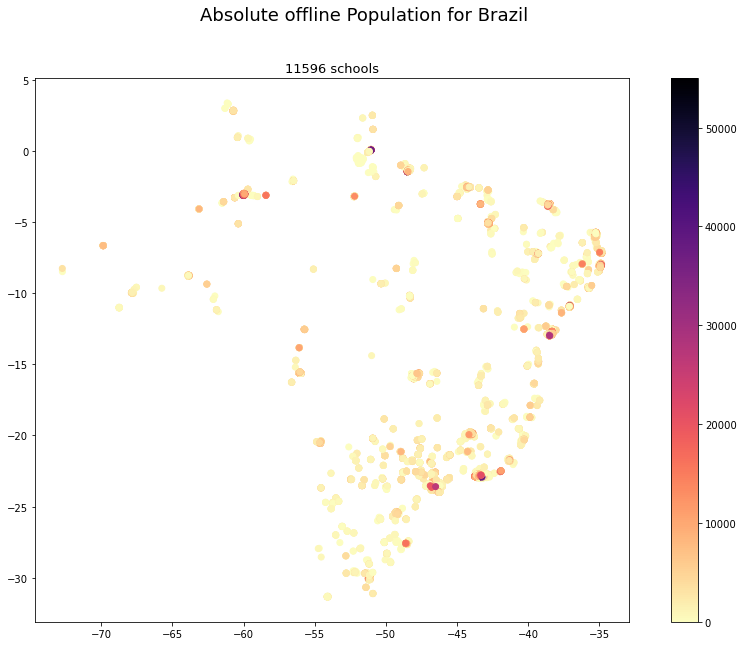

In [28]:
#Set the figure size
fig,ax =plt.subplots(1, figsize=(15,10))

#plotting with the new geodataframe, each school point by prediction value
cmap_reversed = plt.cm.get_cmap('magma_r')
gdf.plot(column=gdf.offlinepop_pred, cmap = cmap_reversed ,legend=True, ax=ax)

# add a title and annotation
plt.suptitle('Absolute offline Population for '+ model_config['country'], fontsize=18, fontweight=3)
plt.title(str(gdf.shape[0]) +' schools', fontsize=13)

#show the plot
plt.show()

In [29]:
#repeat subsetting for schools with no internet available
dataset_off = dataset[dataset.internet_availability == "No"]
prio_off = dataset_off[["source_school_id","school_name", "offlinepop_pred", "offline_p", "offline_g","internet_availability","computer_availability"]]
#prio_off = dataset[["source_school_id", "offlinepop_pred", "offline_p", "offline_g"]]
prio_off.head()

,source_school_id,school_name,offlinepop_pred,offline_p,offline_g,internet_availability,computer_availability
5,11048883,EMEIEF NOSSA SENHORA DO AMPARO,44.947117,0.001692,0.000000,No,No
35,11048590,EIEEF JOJ MIT O MINIM,571.803082,0.040556,0.000000,No,No
56,11117800,EMEIEF SOM DA CRAVIOLA,10105.365477,0.266254,0.221344,No,No
69,12032913,ESC CEI JORGE LUIZ VENANCIO PINTO,2140.307089,0.094612,0.000000,No,No
74,12033111,ESC CRECHE MAURO LIMA,4924.418994,0.193458,0.000000,No,No


In [32]:
#sort, print and export priorization list of offline schools
prio_off= prio_off.sort_values("offlinepop_pred", ascending= False)
print(prio_off.head())
prio_off.to_excel(model_config['model']['loc'] + "predictions/Offline_Priorization_List.xlsx", index= False)

NameError: name 'prio_off' is not defined

In [31]:
#subset geodataframe to only offline schools
offline_schools = gdf.loc[gdf['internet_availability'] == "No"]
offline_schools.shape

(1276, 72)

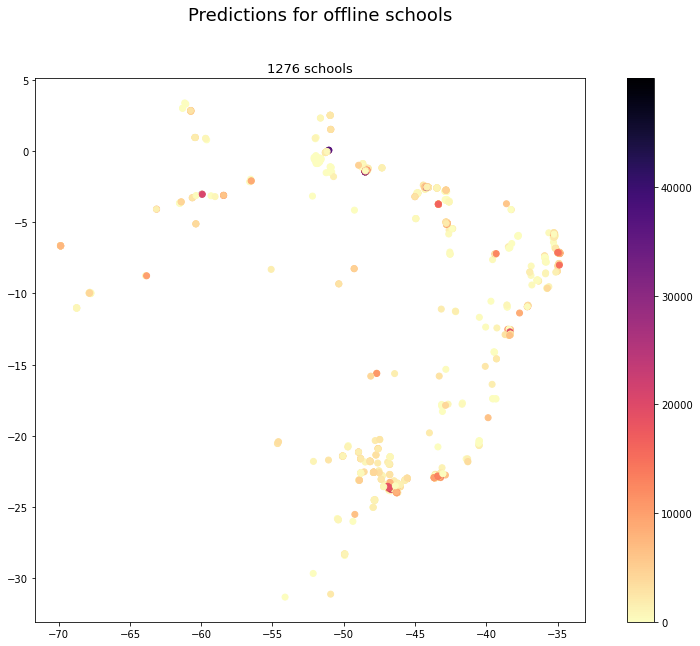

In [32]:
#create figure 
fig,ax =plt.subplots(1, figsize=(15,10))

# add a title and annotation
offline_schools.plot(column=offline_schools.offlinepop_pred, cmap = cmap_reversed ,legend=True, ax=ax)
plt.suptitle('Predictions for offline schools', fontsize=18, fontweight=3)
plt.title(str(offline_schools.shape[0]) + ' schools', fontsize=13)

plt.show()

In [33]:
#repeat subsetting with adding the exclusion of high population outliers 
dataset_low = dataset_off[dataset_off.population < np.percentile(dataset_off.population, 90)]
prio_low = dataset_low[["source_school_id","school_name", "offlinepop_pred", "offline_p", "offline_g","internet_availability","computer_availability"]]
#prio_low = dataset[["source_school_id", "offlinepop_pred", "offline_p", "offline_g"]]
prio_low.head()

,source_school_id,school_name,offlinepop_pred,offline_p,offline_g,internet_availability,computer_availability
5,11048883,EMEIEF NOSSA SENHORA DO AMPARO,44.947117,0.001692,0.000000,No,No
35,11048590,EIEEF JOJ MIT O MINIM,571.803082,0.040556,0.000000,No,No
56,11117800,EMEIEF SOM DA CRAVIOLA,10105.365477,0.266254,0.221344,No,No
69,12032913,ESC CEI JORGE LUIZ VENANCIO PINTO,2140.307089,0.094612,0.000000,No,No
74,12033111,ESC CRECHE MAURO LIMA,4924.418994,0.193458,0.000000,No,No


In [34]:
#sort, print and export priorization list of "low" population schools
prio_low= prio_low.sort_values("offlinepop_pred", ascending= False)
print(prio_low.head())
prio_low.to_excel(model_config['model']['loc'] + "predictions/Offline_Priorization_List_no_outliers.xlsx", index= False)

       source_school_id                          school_name  offlinepop_pred  \
10175          16009878         ESC MUL ANA CRISTINA R BRITO     36963.597863   
4823           35000383             ANTOINE DE SAINT EXUPERY     34190.558063   
9476           21343802                     EM LIRIO DO VALE     30689.735771   
9979           16003713  ESC EST BENEVENUTO SOARES RODRIGUES     30441.626486   
7883           21227780                 EM CRIANCA ESPERANCA     28641.515188   

       offline_p  offline_g internet_availability computer_availability  
10175   0.704285   0.734394                    No                   Yes  
4823    0.570285   0.695699                    No                   Yes  
9476    0.605015   0.656836                    No                    No  
9979    0.670873   0.734394                    No                    No  
7883    0.611691   0.656836                    No                    No  


In [35]:
#subset geodata by excluding 10th decile
offline_schools_no_outliers = offline_schools = offline_schools[offline_schools.population < np.percentile(offline_schools.population, 90)]
offline_schools_no_outliers.shape

(1148, 72)

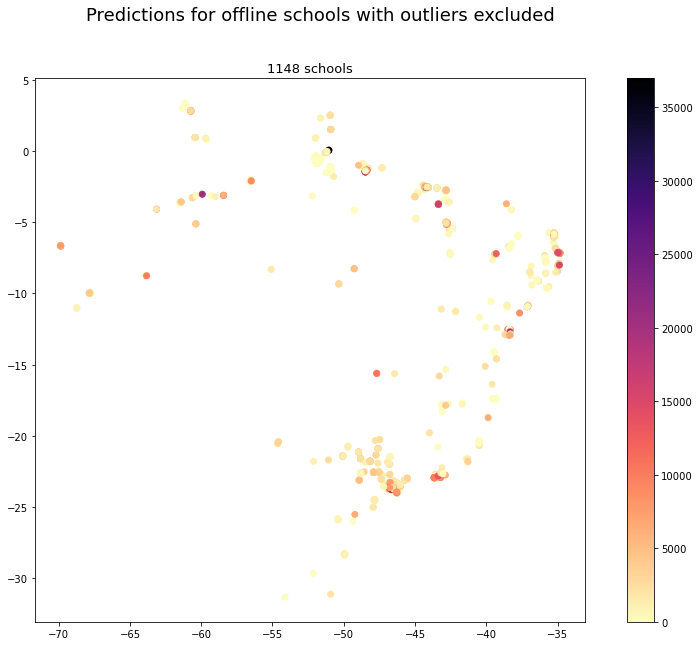

In [36]:
#create figure 
fig,ax =plt.subplots(1, figsize=(15,10))

# add a title and annotation
offline_schools_no_outliers.plot(column=offline_schools_no_outliers.offlinepop_pred, cmap = cmap_reversed ,legend=True, ax=ax)
plt.suptitle('Predictions for offline schools with outliers excluded', fontsize=18, fontweight=3)
plt.title(str(offline_schools_no_outliers.shape[0]) +' schools', fontsize=13)

plt.show()

## Country-level Aggregation

In [37]:
#aggregate online population (predicted) and population to full sample 
totalonlinepop = onlinepop_pred.sum()
totalpop = dataset.population.sum()
#calculate country level online share (predicted)
brazil_online = (totalonlinepop/totalpop)
print("Relative predicted online population:")
print(str(100*np.round(brazil_online,4)) + ' %')

#multiply with population data to create estimate of total online population
#official population data taken from: https://data.worldbank.org/indicator/SP.POP.TOTL?locations=BR
brazil_online_abs= model_config["country_pop"] * (brazil_online)
print("Absolute predicted online population:")
print(int(brazil_online_abs))

Relative predicted online population:
78.41 %
Absolute predicted online population:
166677651


In [38]:
#aggregate online population (ground truth) to full sample 
totalonlinepop_gt = onlinepop_gt.sum()
totalpop = dataset.population.sum()
#calculate country level online share (ground truth)
brazil_online_gt = (totalonlinepop_gt/totalpop)
print("Relative ground truth online population:")
print(str(100*np.round(brazil_online_gt,4)) + ' %')

#multiply with population data to create estimate of total online population
#official population data taken from: https://data.worldbank.org/indicator/SP.POP.TOTL?locations=BR
brazil_online_abs_gt = model_config["country_pop"] * (brazil_online_gt)
print("Absolute ground truth online population:")
print(int(brazil_online_abs_gt))

Relative ground truth online population:
75.52 %
Absolute ground truth online population:
160523053
